In [46]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


Loading the Karate Club Graph

In [47]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=4)

Function to try split a subgraph using modularity matrix

In [48]:
def try_split(G_sub):
    nodes = list(G_sub)
    A = nx.to_numpy_array(G_sub, nodelist=nodes)
    k = np.array([d for _, d in G_sub.degree()], float)
    m = G_sub.number_of_edges()

    B = A - (np.outer(k, k)) / (2 * m)

    eigvals, eigvecs = np.linalg.eigh(B)
    max_idx = np.argmax(eigvals)

    if eigvals[max_idx] <= 0:
        return [], []

    lead_vec = eigvecs[:, max_idx]
    left = [nodes[i] for i, v in enumerate(lead_vec) if v > 0]
    right = [nodes[i] for i, v in enumerate(lead_vec) if v <= 0]
    return left, right


Visualization after each plot

In [49]:
def draw_communities(G_full, pos, comms, step_no):
    color_map = {}
    colors = ["blue","green","red","purple","brown","white"]

    for i, comm in enumerate(comms):
        for node in comm:
            color_map[node] = colors[i % len(colors)]

    node_colors = [color_map.get(n, "tab:blue") for n in G_full.nodes()]

    plt.figure(figsize=(9, 6))
    nx.draw(
        G_full, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        edgecolors="black",
        linewidths=0.8
    )
    plt.title(f"After Split #{step_no} | Total Communities: {len(comms)}")
    plt.axis("off")
    plt.show()


Centrality metrics

In [50]:
def init_history(G_full):
    metrics = ["degree", "betweenness", "closeness", "clustering"]
    return {m: {n: [] for n in G_full.nodes()} for m in metrics}

def record_metrics(G_full, comms, hist):
    deg_all = {n: 0.0 for n in G_full.nodes()}
    bet_all = {n: 0.0 for n in G_full.nodes()}
    clo_all = {n: 0.0 for n in G_full.nodes()}
    clu_all = {n: 0.0 for n in G_full.nodes()}

    for comm in comms:
        sub = G_full.subgraph(comm)
        if len(sub) > 1:
            deg = nx.degree_centrality(sub)
            bet = nx.betweenness_centrality(sub)
            clo = nx.closeness_centrality(sub)
            clu = nx.clustering(sub)
            for n in sub.nodes():
                deg_all[n] = deg[n]
                bet_all[n] = bet[n]
                clo_all[n] = clo[n]
                clu_all[n] = clu[n]

    for n in G_full.nodes():
        hist["degree"][n].append(deg_all[n])
        hist["betweenness"][n].append(bet_all[n])
        hist["closeness"][n].append(clo_all[n])
        hist["clustering"][n].append(clu_all[n])


Recursive Splitting !!

In [51]:
def split_and_record(G_sub, G_full, pos, comms, hist, step):
    left, right = try_split(G_sub)
    if not left or not right:
        return

    target = set(G_sub.nodes())
    for i, comm in enumerate(comms):
        if comm == target:
            comms.pop(i)
            comms.append(set(left))
            comms.append(set(right))
            break

    step[0] += 1
    record_metrics(G_full, comms, hist)
    draw_communities(G_full, pos, comms, step[0])

    split_and_record(G_full.subgraph(left), G_full, pos, comms, hist, step)
    split_and_record(G_full.subgraph(right), G_full, pos, comms, hist, step)

# Printing final communities
def show_final_communities(comms):
    print("\nFinal communities:")
    for i, c in enumerate(comms, start=1):
        print(f"  Community {i} ({len(c)}): {sorted(list(c))}")


Plot for all node metrics

In [52]:
def plot_all_metrics(G_full, hist):
    steps = list(range(len(next(iter(hist["degree"].values())))))

    def plot_metric(key, ylabel):
        plt.figure(figsize=(11, 5))
        colors = plt.cm.tab20(np.linspace(0, 1, len(G_full.nodes())))
        for i, n in enumerate(sorted(G_full.nodes())):
            plt.plot(steps, hist[key][n], marker='o', linewidth=1.5,
                     color=colors[i], label=f'Node {n}', alpha=0.7)
        plt.xticks(steps, [f'Split {i}' for i in steps])
        plt.xlabel('Split Step')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} Over Splits')
        plt.grid(True, alpha=0.3)

        handles, labels = plt.gca().get_legend_handles_labels()
        if len(labels) > 15:
            plt.legend(handles[::3], labels[::3], loc='center left', bbox_to_anchor=(1, 0.5),
                       title='Nodes', fontsize=8, title_fontsize=9)
        else:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                       title='Nodes', fontsize=8, title_fontsize=9)

        plt.tight_layout()
        plt.show()

    plot_metric('degree', 'Degree Centrality')
    plot_metric('betweenness', 'Betweenness Centrality')
    plot_metric('closeness', 'Closeness Centrality')
    plot_metric('clustering', 'Clustering Coefficient')

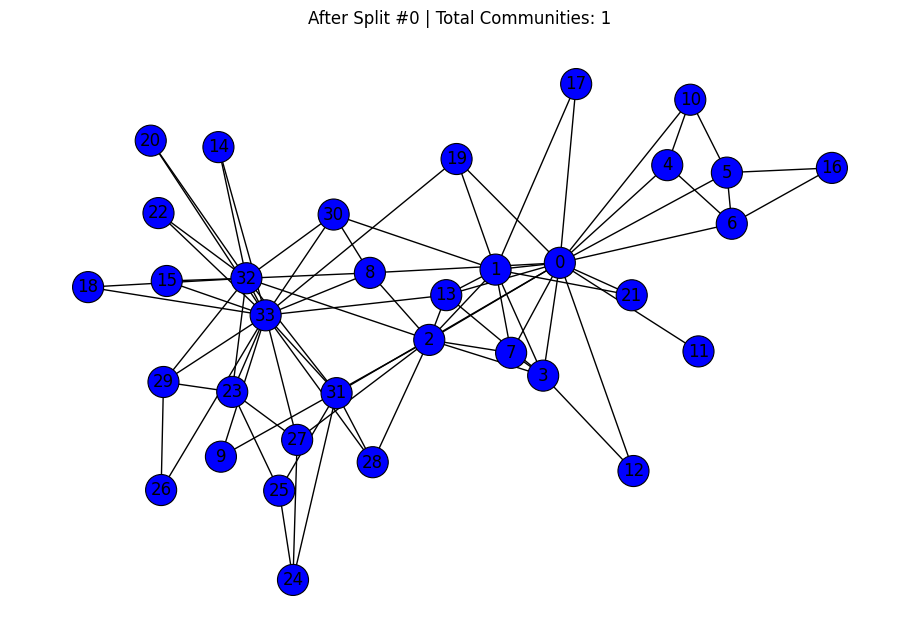

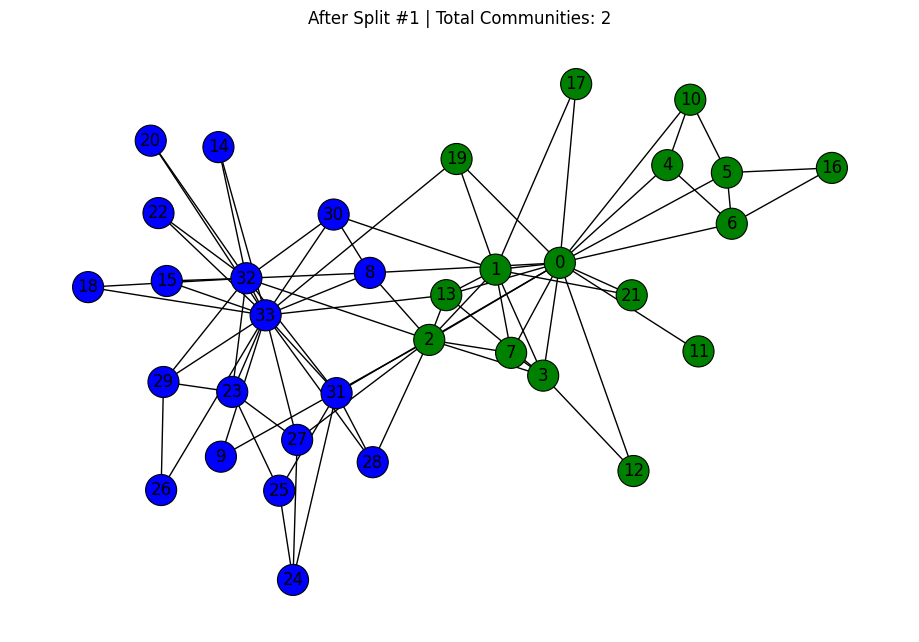

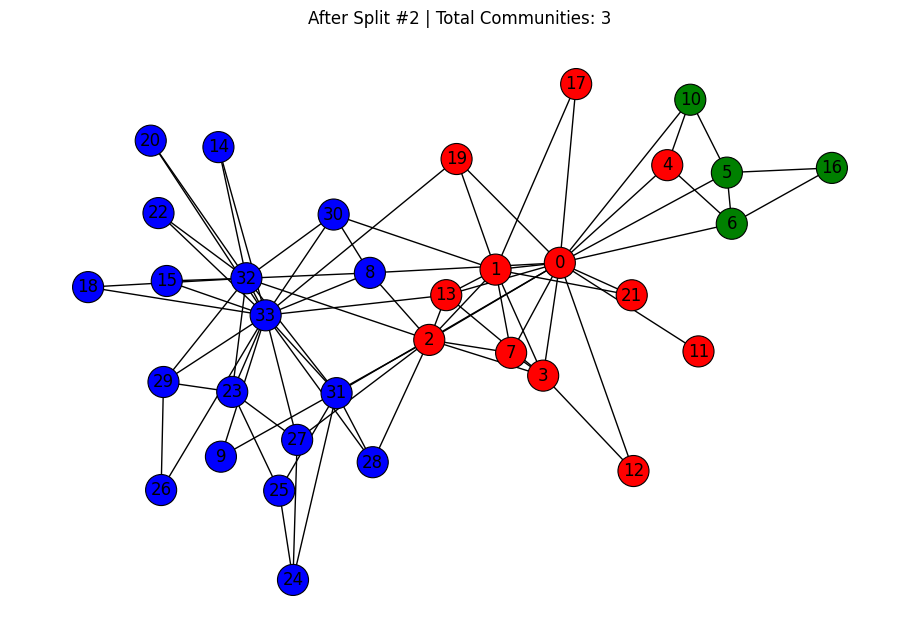


Final communities:
  Community 1 (18): [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  Community 2 (4): [5, 6, 10, 16]
  Community 3 (12): [0, 1, 2, 3, 4, 7, 11, 12, 13, 17, 19, 21]


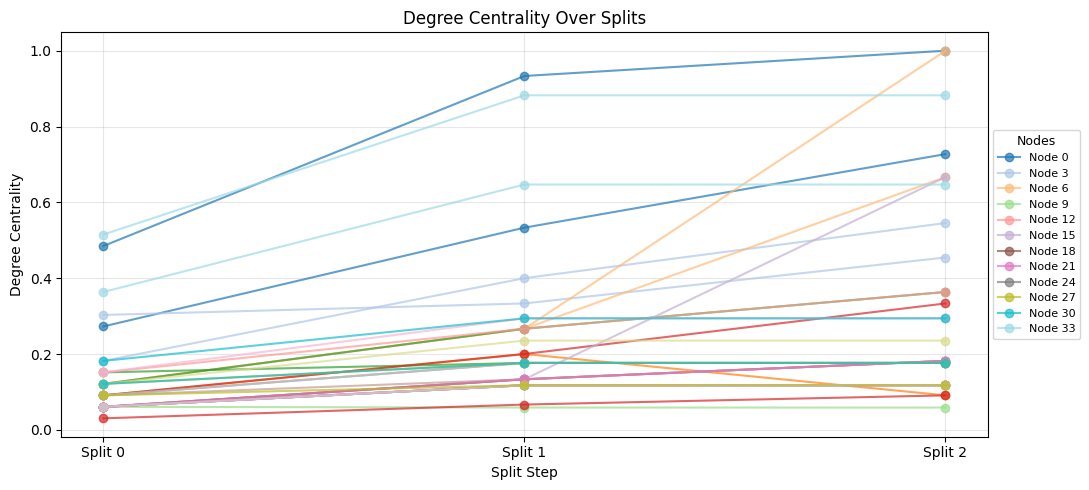

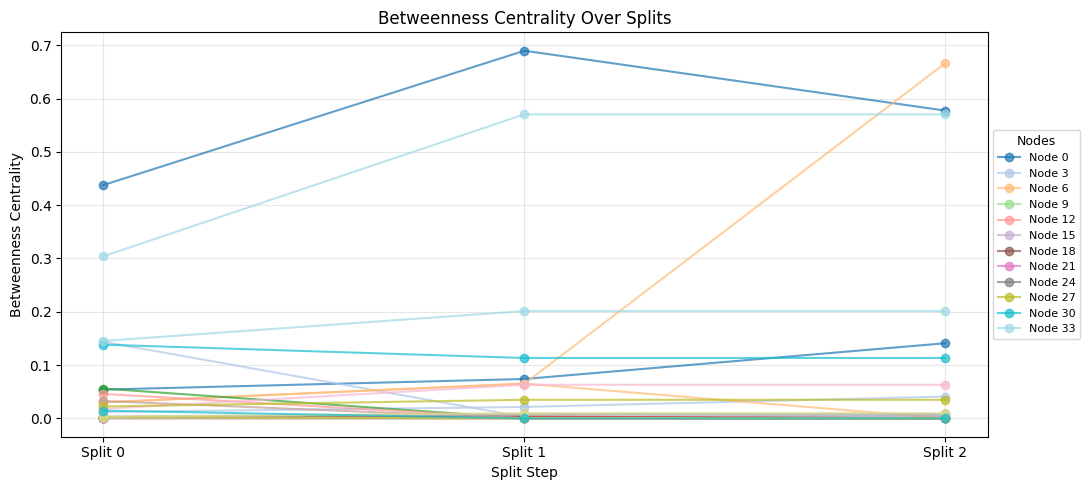

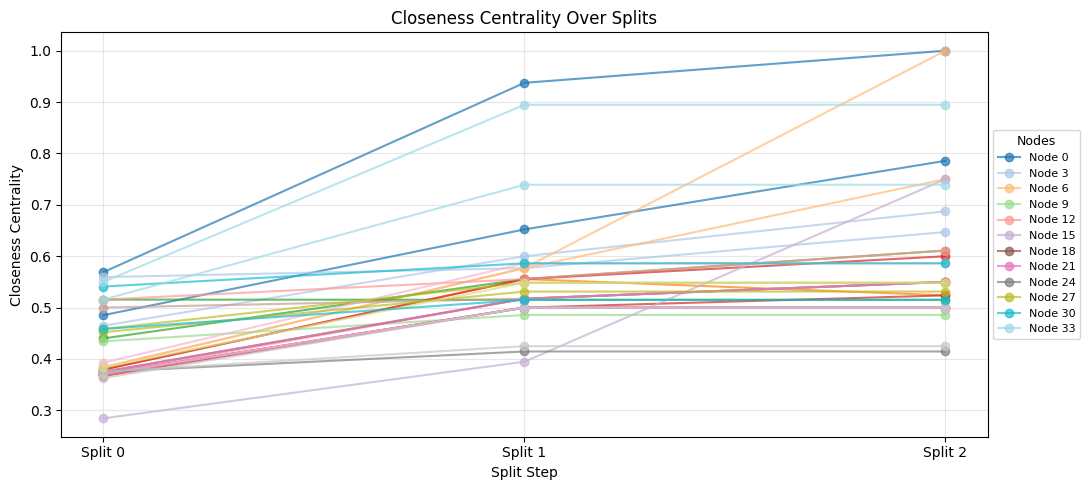

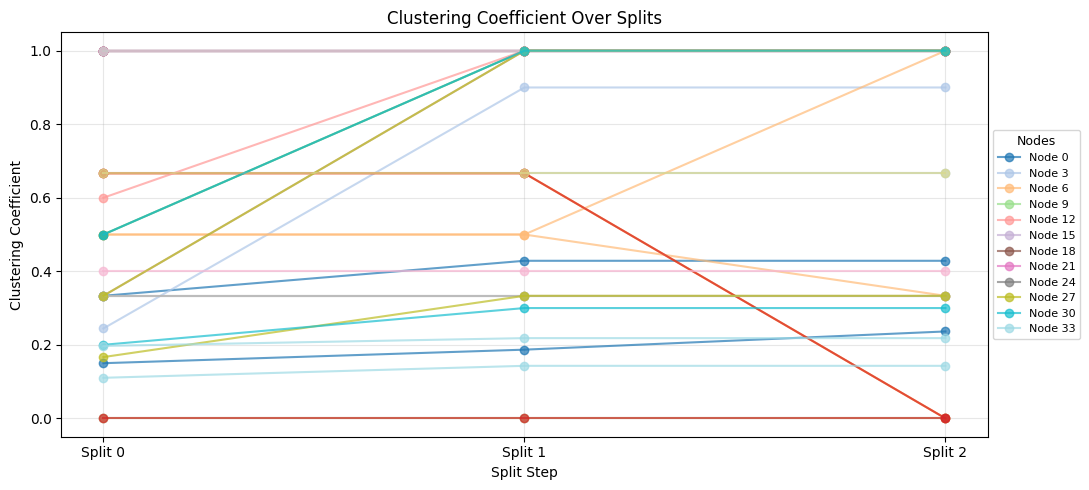

In [53]:
communities = [set(G.nodes())]
history = init_history(G)
record_metrics(G, communities, history)
draw_communities(G, pos, communities, step_no=0)

step_counter = [0]
split_and_record(G, G, pos, communities, history, step_counter)

show_final_communities(communities)
plot_all_metrics(G, history)